# Preprocessing Data

## Installation Libs

In [41]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Libs

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Code

### Useful func

In [47]:

def analyze_country(file_path, country_name, result_path):
    df = pd.read_csv(file_path)

    # Parsing date
    df["date"] = pd.to_datetime(df["date"])
    df["release_date"] = pd.to_datetime(df["release_date"])
    df["is_explicit"] = df["is_explicit"].astype(bool)
    df["duration_sec"] = df["duration_ms"] / 1000

    print(f"\n Analize: {country_name}")
    print(df.info())

    # --- Plot 1: Mean Popularity per day ---
    plt.figure()
    df.groupby("date")["popularity"].mean().plot()
    plt.title(f"Mean Popularity per Day - {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Mean Popularity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{result_path}/{country_name}_mean_popularity.png")
    plt.show()

    # --- Plot 2: Duration Distribution ---
    plt.figure()
    sns.histplot(df["duration_sec"], bins=30, kde=True)
    plt.title(f"Tracks Distribution Duration - {country_name}")
    plt.xlabel("Duration (s)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"{result_path}/{country_name}_distribution_duration.png")
    plt.show()

    # --- Plot 3: Explicity vs Non-Explity ---
    plt.figure()
    sns.countplot(data=df, x="is_explicit", palette="Set2")
    plt.title(f"Explicit Tracks vs non - {country_name}")
    plt.xlabel("Esplicity")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.tight_layout()
    plt.savefig(f"{result_path}/{country_name}_explicit_tracks.png")
    plt.show()
    
    # --- Plot 4: Top Artists per Mean Popularity ---
    top_artists = df.groupby("artist")["popularity"].mean().sort_values(ascending=False).head(10)
    plt.figure()
    sns.barplot(x=top_artists.values, y=top_artists.index, palette="viridis")
    plt.title(f"Top 10 Artists per Mean Popularity - {country_name}")
    plt.xlabel("Mean Popularity")
    plt.ylabel("Artist")
    plt.tight_layout()
    plt.savefig(f"{result_path}/{country_name}_top_artists.png")
    plt.show()

In [48]:
# Plot Settings
plt.rcParams['figure.figsize'] = (8, 4)

In [49]:
# Data Folder
folder_path = "../data"
all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]


 Analize: Italy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


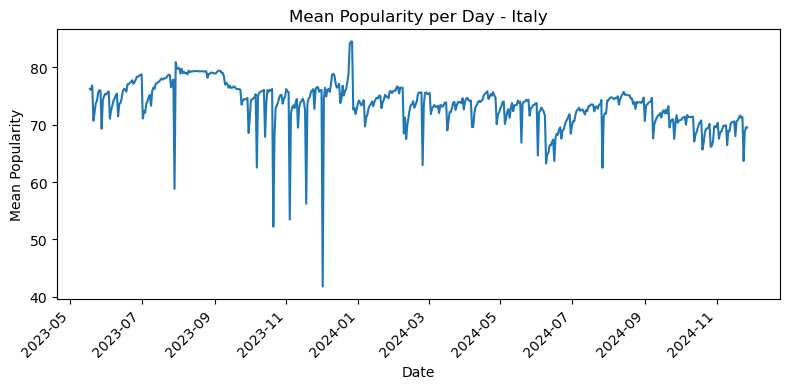

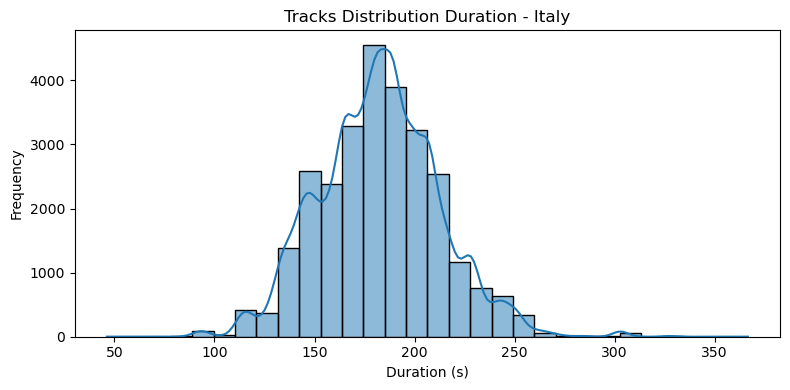

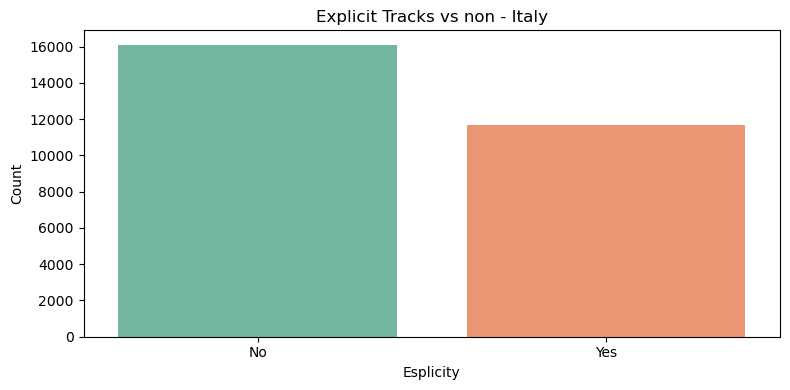

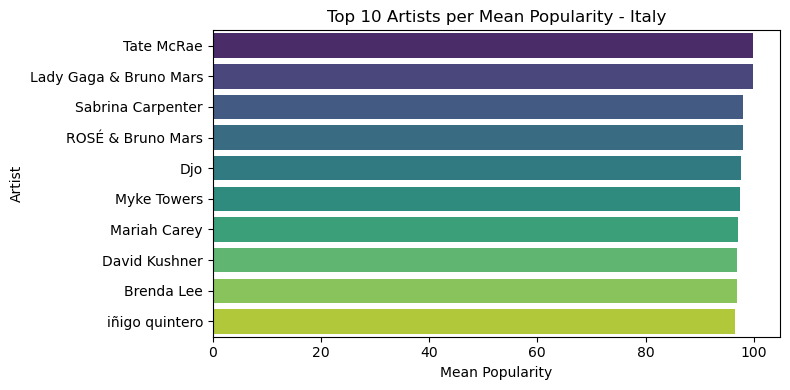


 Analize: Uk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


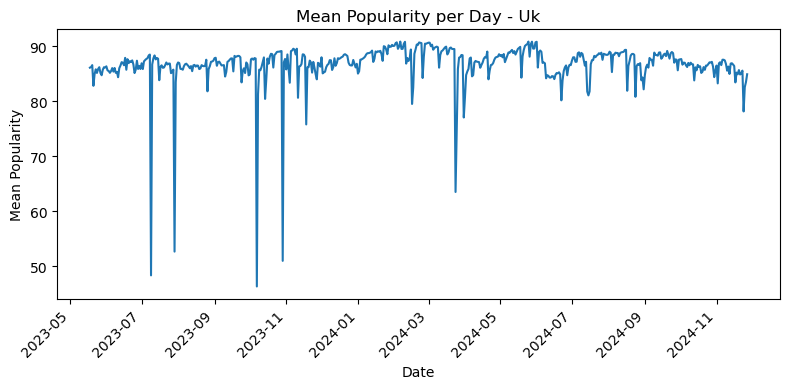

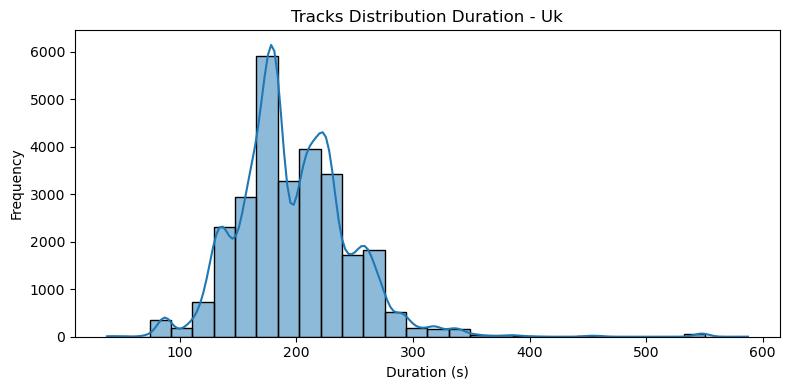

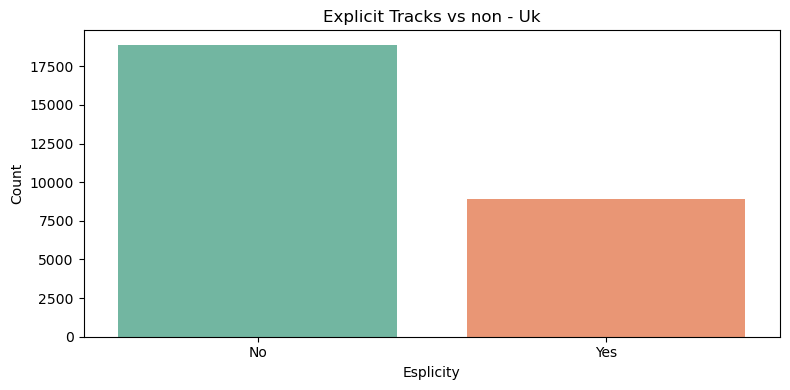

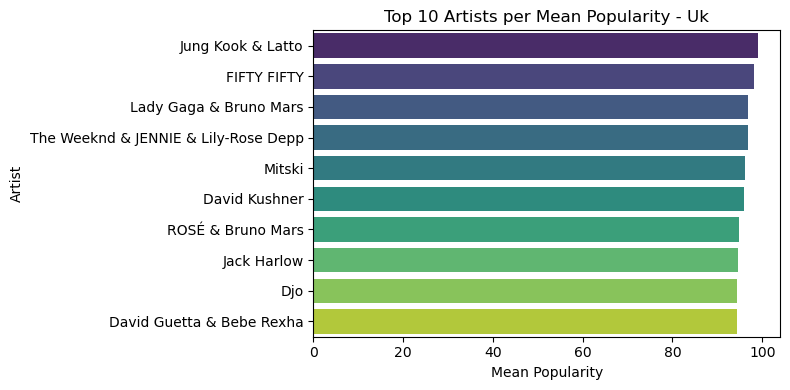


 Analize: World
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


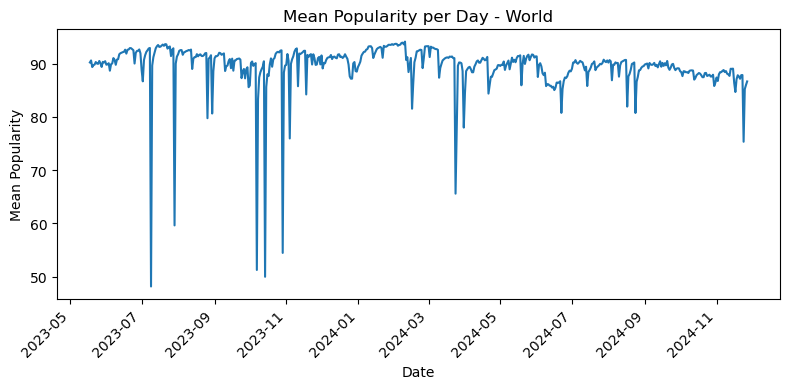

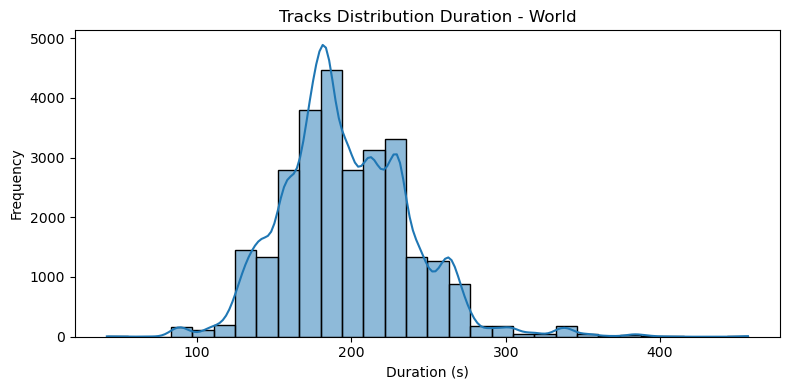

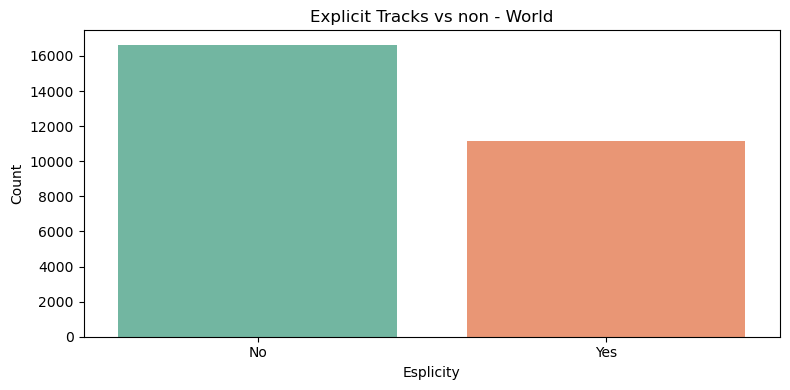

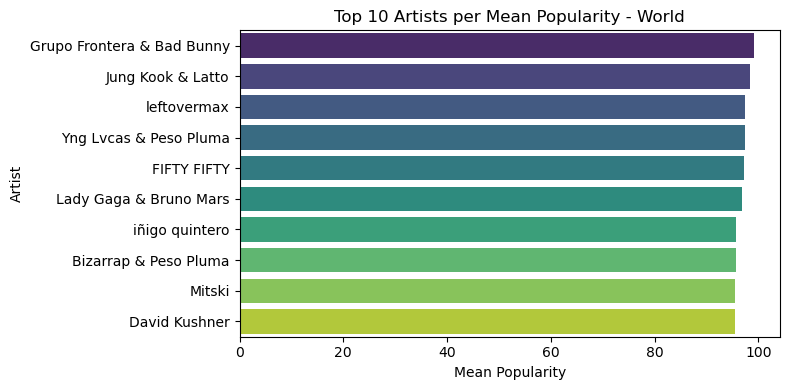


 Analize: Japan
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


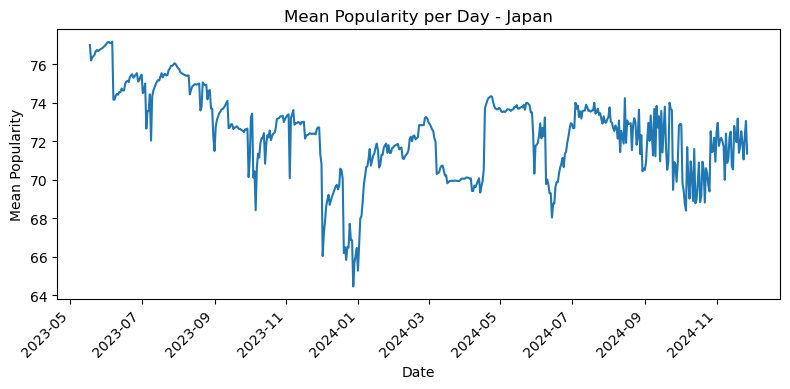

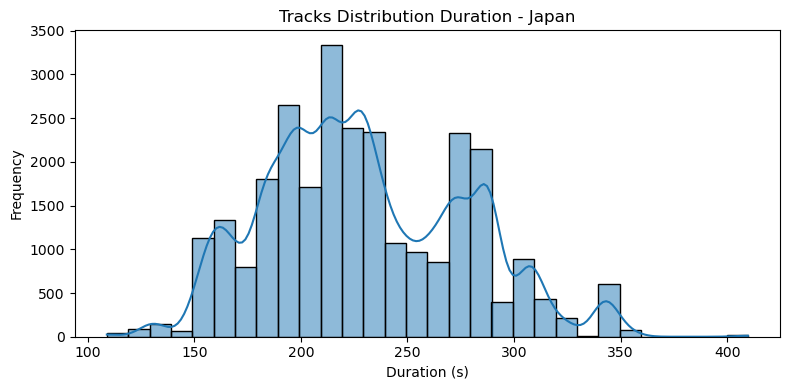

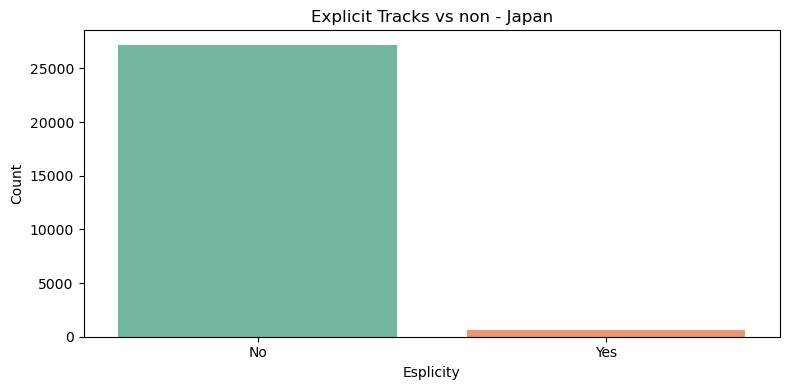

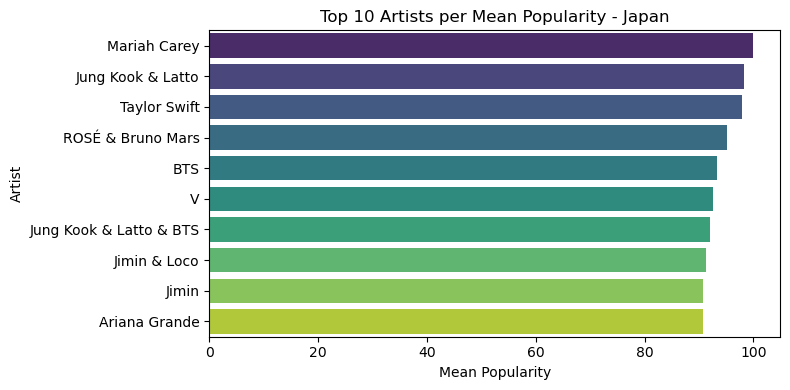


 Analize: France
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27799 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


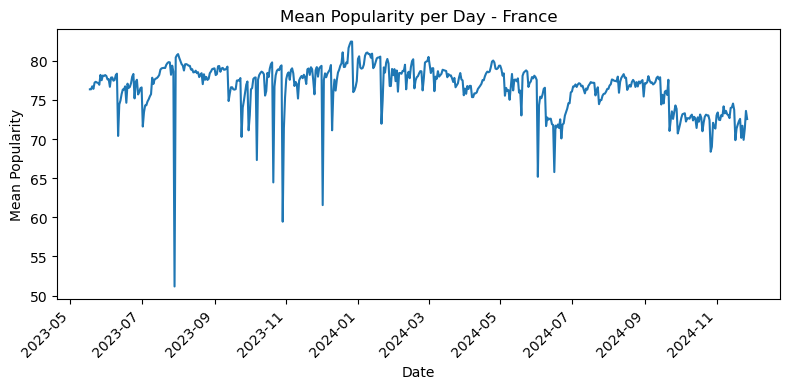

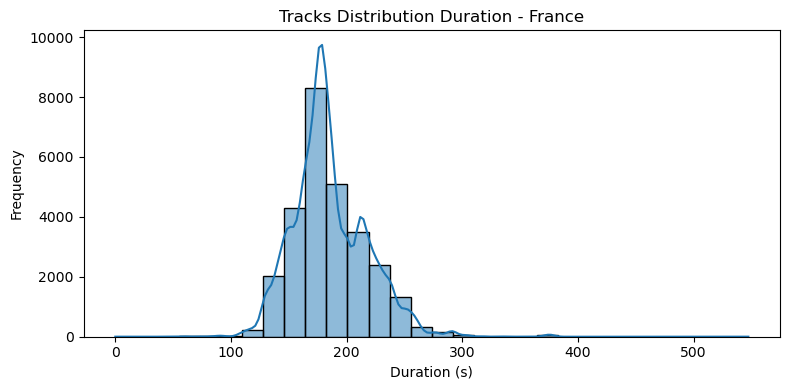

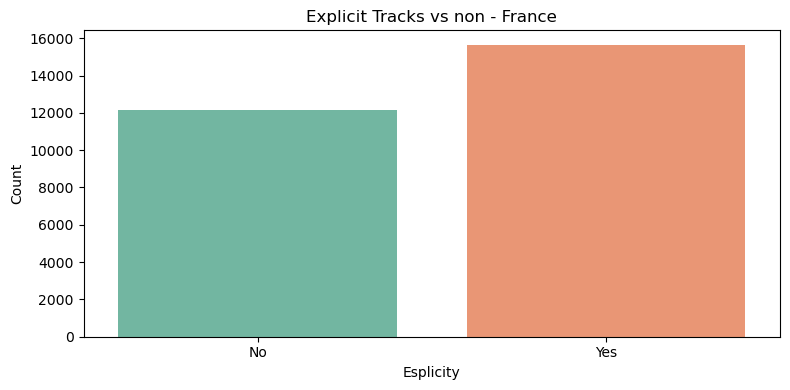

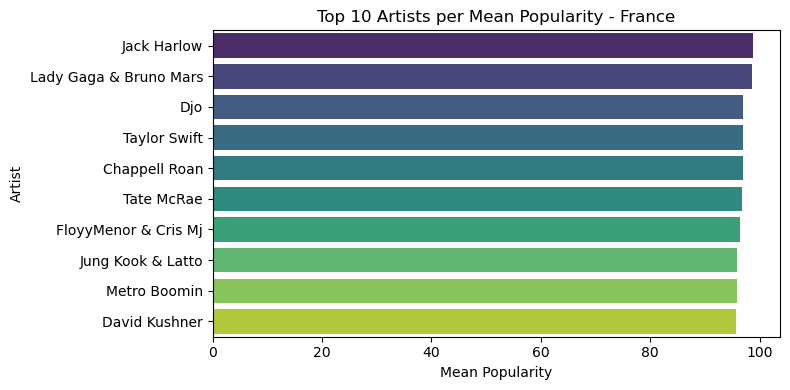


 Analize: Spain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


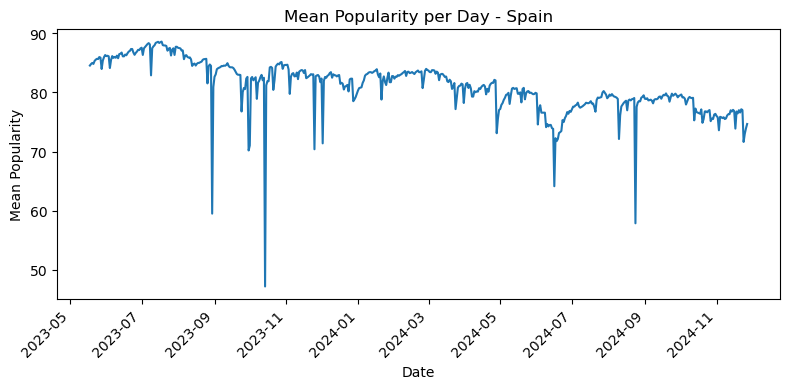

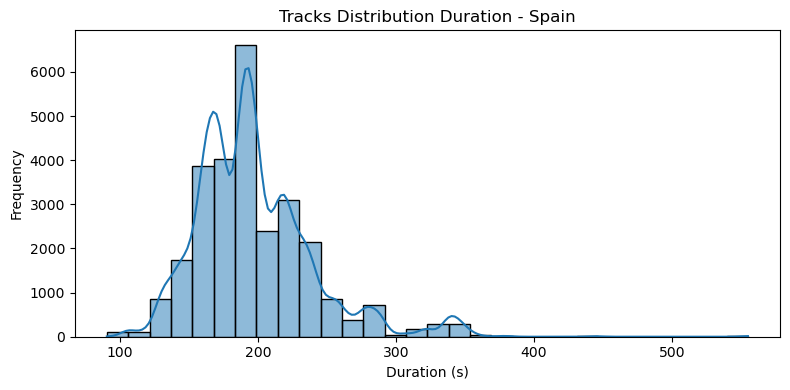

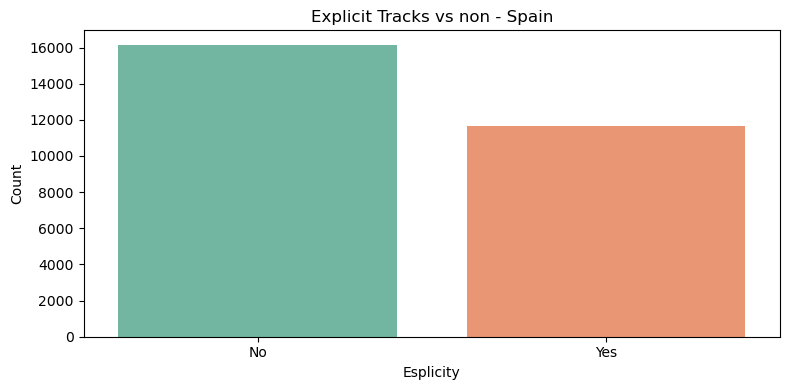

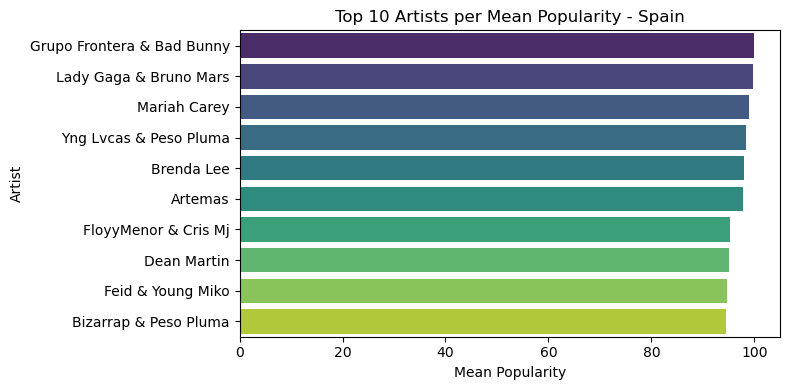


 Analize: Mexic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


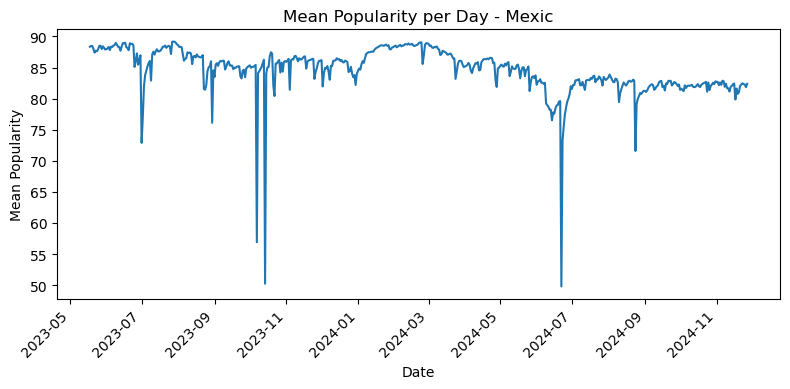

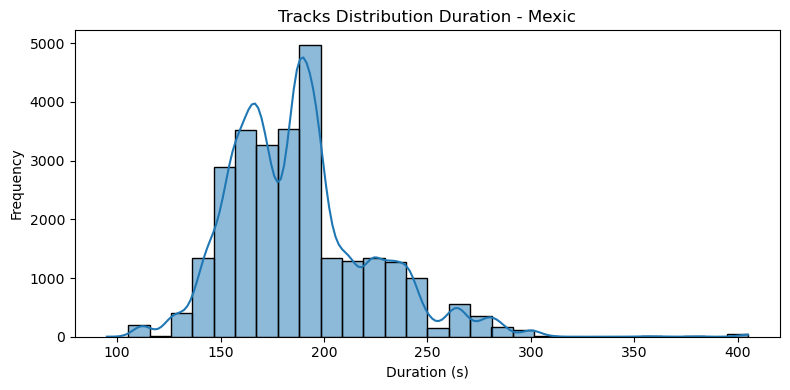

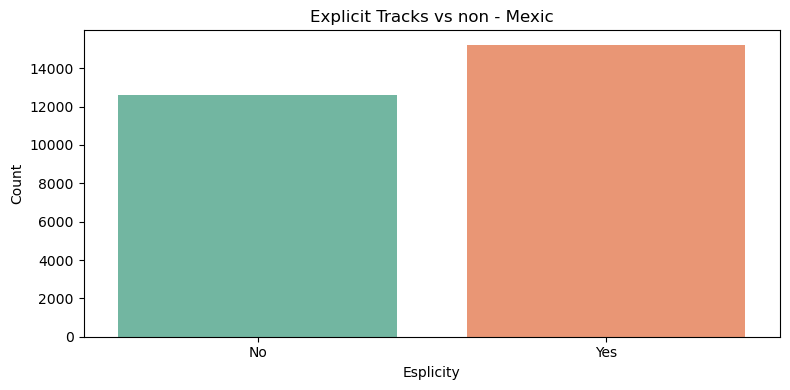

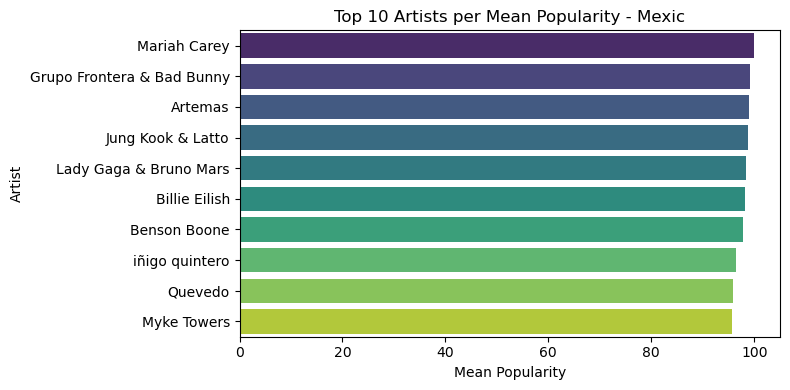


 Analize: Usa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


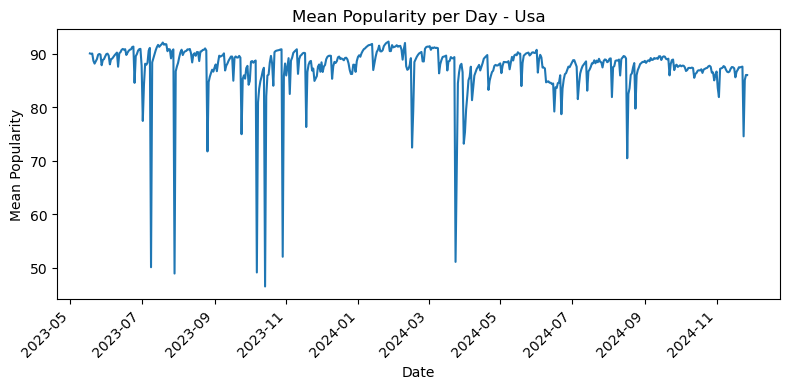

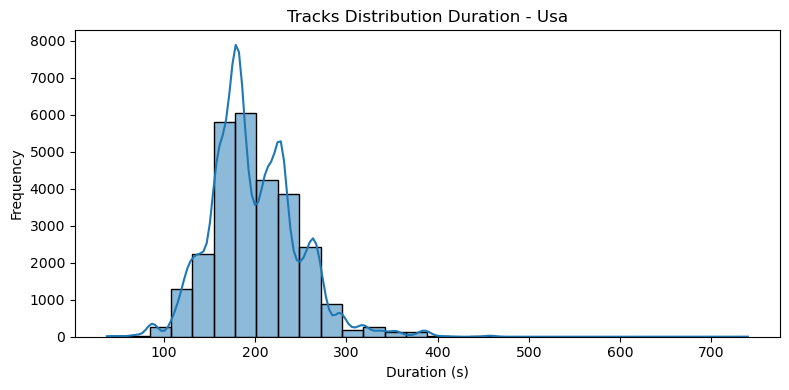

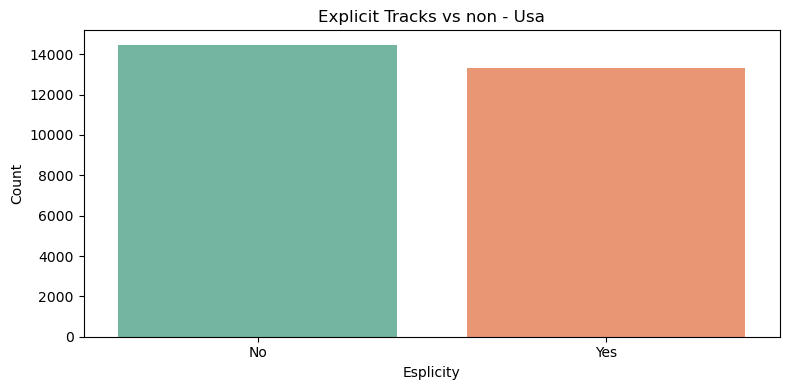

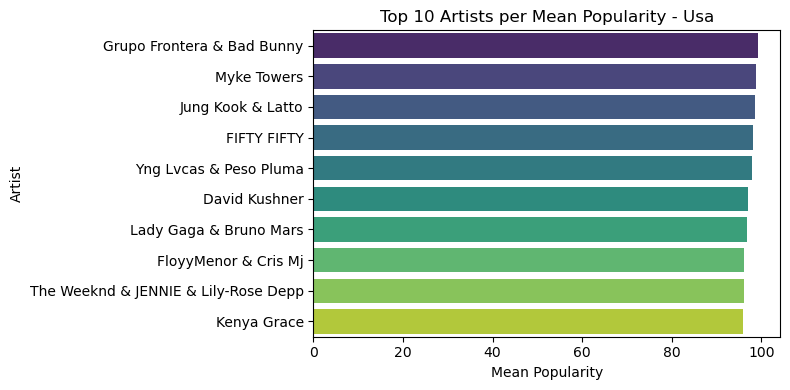


 Analize: South korea
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


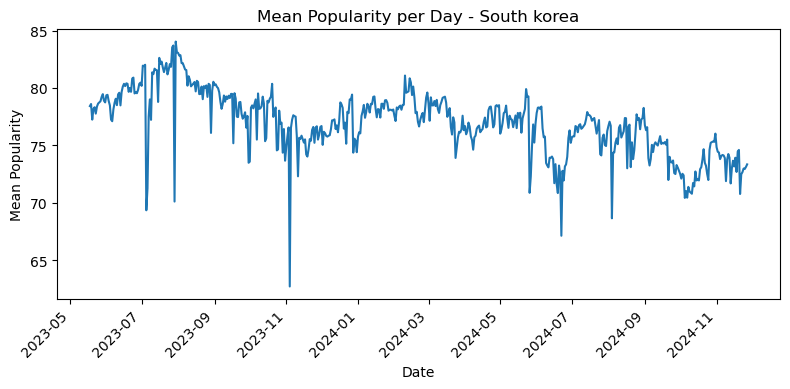

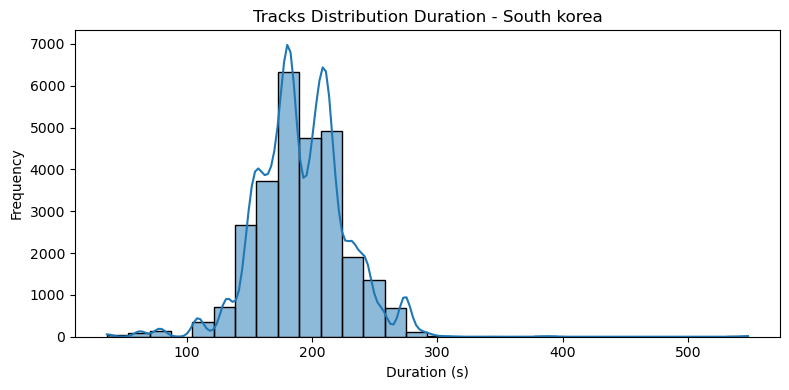

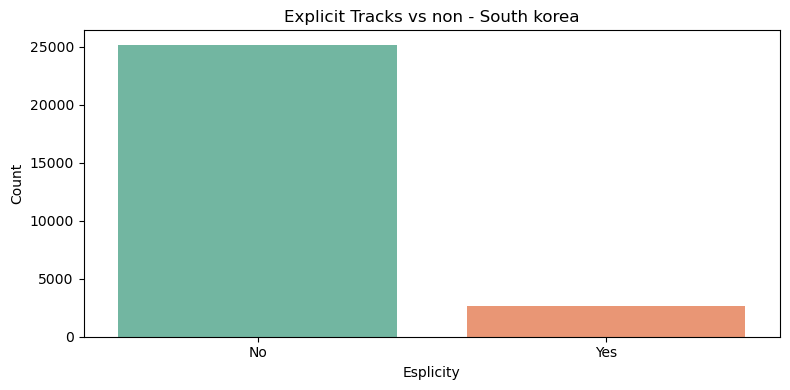

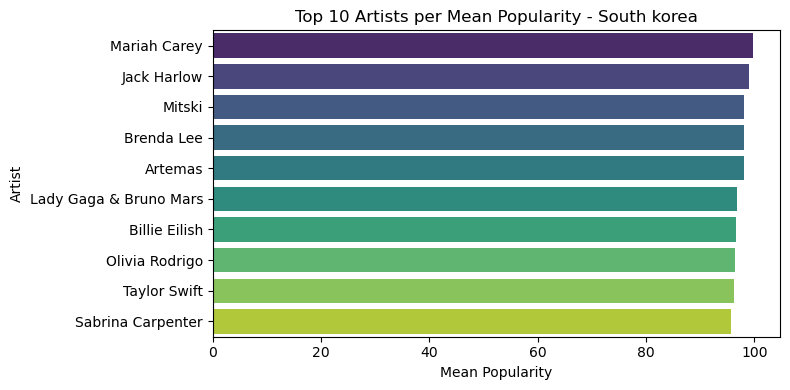


 Analize: Argentina
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27800 entries, 0 to 27799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             27800 non-null  datetime64[ns]
 1   position         27800 non-null  int64         
 2   song             27800 non-null  object        
 3   artist           27800 non-null  object        
 4   popularity       27800 non-null  int64         
 5   duration_ms      27800 non-null  int64         
 6   album_type       27800 non-null  object        
 7   total_tracks     27800 non-null  int64         
 8   release_date     27800 non-null  datetime64[ns]
 9   is_explicit      27800 non-null  bool          
 10  album_cover_url  27800 non-null  object        
 11  duration_sec     27800 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.4+ MB
None


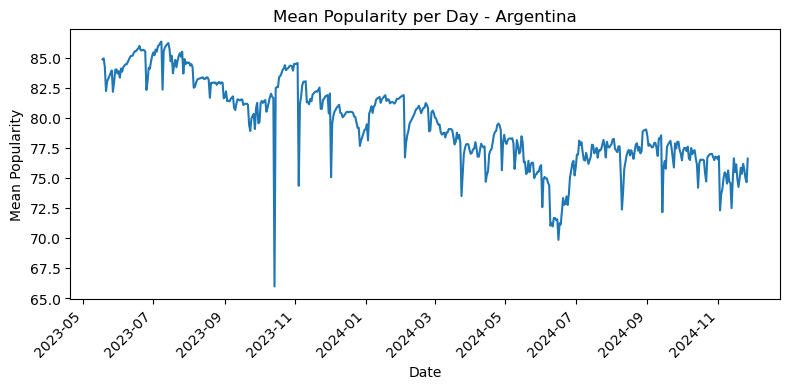

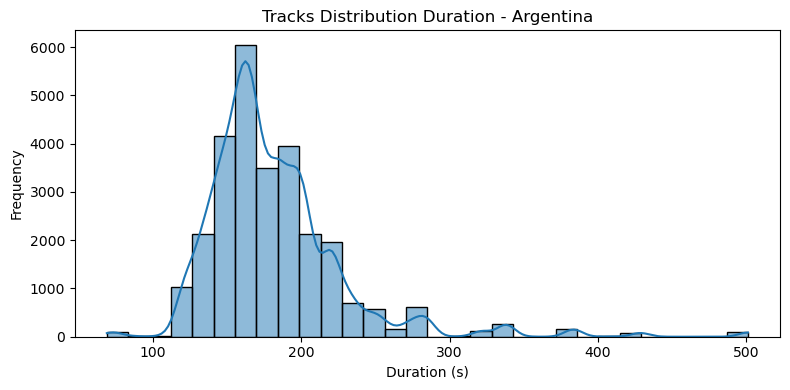

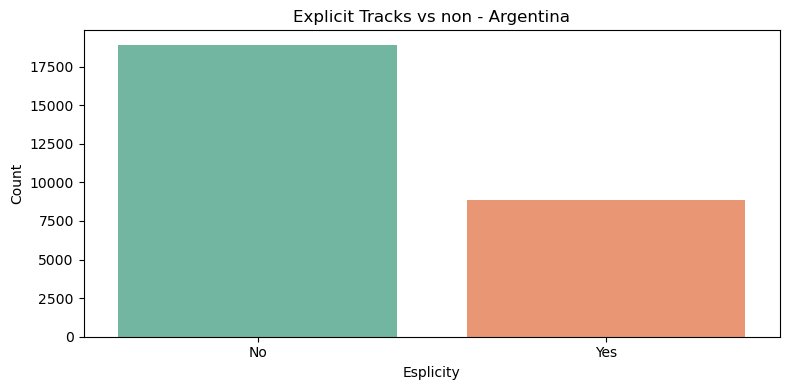

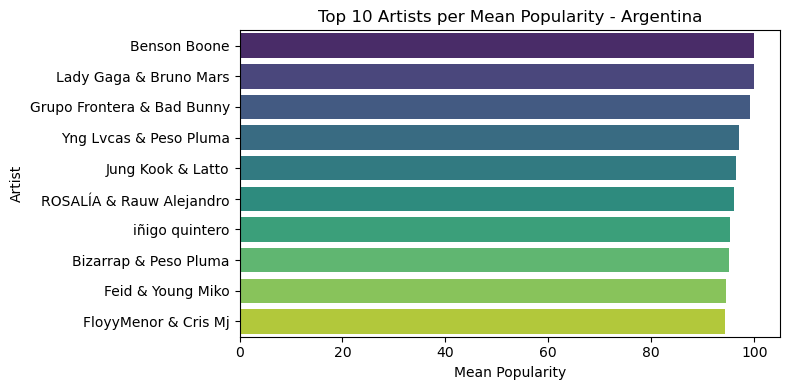

In [50]:
# Exec Analysis
results_path = "../img"
if not os.path.exists(results_path):
    os.makedirs(results_path)

for file in all_files:
    country_name = os.path.splitext(file)[0].capitalize()
    file_path = os.path.join(folder_path, file)
    analyze_country(file_path, country_name, results_path)